In [1]:
import numpy as np
import pickle
import os
import rasterio
from pyproj import Transformer
import numpy as np
import matplotlib.pyplot as plt
import random
import geopandas as gpd
import pandas as pd
from shapely import wkt
from tqdm import tqdm
from typing import List
import torch
from torch.utils.data import Dataset


def load(save_path):
    with open(save_path, "rb") as f:
       data = pickle.load(f)
    print("✅ Data loaded successfully!")

    return data

In [8]:
class TemporalPatch:
    def __init__(self, patch_id, data_patch):
        self.patch_id = patch_id

        # internal protected attributes (immutable from outside)
        self._years = list(data_patch[patch_id]['years'])                      # copy
        self._imgs = np.copy(data_patch[patch_id]['imgs'])                     # copy
        self._coords = np.copy(data_patch[patch_id]['coords'])                 # copy
        self._iris_index = np.copy(data_patch[patch_id]['iris_index'])         # copy
        self._iris_props = list(data_patch[patch_id]['iris_patch_proportions'])# shallow copy
        self._socioeco = np.copy(data_patch[patch_id]['socioeco'])             # copy

    # --------- READ-ONLY PROPERTIES ---------
    @property
    def years(self):
        return list(self._years)  # safe copy

    @property
    def imgs(self):
        return np.copy(self._imgs)  # safe copy

    @property
    def coords(self):
        return np.copy(self._coords)  # safe copy

    @property
    def iris_index(self):
        return np.copy(self._iris_index)  # safe copy

    @property
    def iris_props(self):
        return list(self._iris_props)  # safe copy

    @property
    def socioeco(self):
        return np.copy(self._socioeco)  # safe copy

    # --------- GET YEAR ---------
    def get_year(self, year):
        if year not in self._years:
            raise ValueError(f"Year {year} not available. Available: {self._years}")

        idx = self._years.index(year)

        # return copies → safe & immutable
        return {
            "img": np.copy(self._imgs[idx]),
            "coords": np.copy(self._coords[idx]),
            "iris_index": np.copy(self._iris_index[idx]),
            "iris_props": self._iris_props[idx],  # if dict/list, user gets a separate reference anyway
            "socioeco": np.copy(self._socioeco[idx])
        }

    # --------- GET RANGE ---------
    def get_range(self, start_year, end_year):
        if start_year not in self._years or end_year not in self._years:
            raise ValueError(f"Invalid year range {start_year}–{end_year}. Available: {self._years}")

        idx1 = self._years.index(start_year)
        idx2 = self._years.index(end_year) + 1

        return {
            "years": self._years[idx1:idx2].copy(),
            "imgs": np.copy(self._imgs[idx1:idx2]),
            "coords": np.copy(self._coords[idx1:idx2]),
            "iris_index": np.copy(self._iris_index[idx1:idx2]),
            "iris_props": self._iris_props[idx1:idx2].copy(),
            "socioeco": np.copy(self._socioeco[idx1:idx2]),
        }

    # --------- PLOTTING ---------
    def plot_across_years(self, years_subset=None):
        # Determine which years to plot
        if years_subset is None:
            years_subset = self._years

        indices = [self._years.index(y) for y in years_subset]
        imgs = self._imgs[indices]  # safe read-only view

        n = len(imgs)
        cols = 3
        rows = (n + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
        axes = axes.flatten()

        for ax, img, year in zip(axes, imgs, years_subset):
            ax.imshow(img)
            ax.set_title(f"Year {year}")
            ax.axis("off")

        # Disable unused axes
        for ax in axes[n:]:
            ax.axis("off")

        plt.tight_layout()
        plt.show()

    # --------- UTILITIES ---------
    def __len__(self):
        return len(self._years)

    def __repr__(self):
        return f"TemporalPatch(id={self.patch_id}, years={len(self._years)})"


In [3]:
def load_patches(path: str) -> List["TemporalPatch"]:
    with open(path, "rb") as f:
        patches = pickle.load(f)

    if not isinstance(patches, list):
        raise TypeError("Expected a list of TemporalPatch objects.")

    for i, p in enumerate(patches):
        if not isinstance(p, TemporalPatch):
            raise TypeError(
                f"Item {i} is not a TemporalPatch (got {type(p)})"
            )

    print(f"✔ Loaded {len(patches)} patches.")
    return patches

path = r"C:\Users\adamh\Desktop\Satelite_images\pkl_files\Paris.pkl"
data = load_patches(path)

✔ Loaded 500 patches.


In [4]:
def print_temporal_patches(patches, max_items=None):
    print(f"📦 Dataset contains {len(patches)} TemporalPatch objects\n")

    for i, p in enumerate(patches):
        print(f"🔹 Patch {i}")
        print(f"   id            : {p.patch_id}")
        print(f"   years         : {p.years}")
        print(f"   imgs          : shape={p.imgs.shape}, dtype={p.imgs.dtype}")
        print(f"   coords        : shape={p.coords.shape}")
        print(f"   iris_index    : shape={p.iris_index.shape}")
        print(f"   iris_props    : {len(p.iris_props)} elements")
        print(f"   socioeco      : shape={p.socioeco.shape}")
        print("-" * 50)

        if max_items is not None and i + 1 >= max_items:
            print("… output truncated …")
            break

print_temporal_patches(data)

📦 Dataset contains 500 TemporalPatch objects

🔹 Patch 0
   id            : 0
   years         : [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
   imgs          : shape=(9, 128, 128, 3), dtype=uint8
   coords        : shape=(9, 128, 128, 2)
   iris_index    : shape=(9, 128, 128)
   iris_props    : 9 elements
   socioeco      : shape=(9, 96)
--------------------------------------------------
🔹 Patch 1
   id            : 1
   years         : [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
   imgs          : shape=(9, 128, 128, 3), dtype=uint8
   coords        : shape=(9, 128, 128, 2)
   iris_index    : shape=(9, 128, 128)
   iris_props    : 9 elements
   socioeco      : shape=(9, 96)
--------------------------------------------------
🔹 Patch 2
   id            : 2
   years         : [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
   imgs          : shape=(9, 128, 128, 3), dtype=uint8
   coords        : shape=(9, 128, 128, 2)
   iris_index    : shape=(9, 128, 128)
   

In [5]:
import pickle

class TemporalPatchDataset:
    def __init__(self):
        self.cities = {}      # city_name -> list[TemporalPatch]
        self.patches = []     # flat list of TemporalPatch
        self.socioeco = []    # flat list of socioeco arrays
        self.index = []       # (city, local_patch_index)

    # ---------- LOADING ----------
    def load_city(self, city_name: str, pkl_path: str):
        with open(pkl_path, "rb") as f:
            patches = pickle.load(f)

        if not isinstance(patches, list):
            raise TypeError(f"{city_name} pickle must contain a list")

        self.cities[city_name] = patches

        for i, patch in enumerate(patches):
            self.patches.append(patch)

            # store socioeco aligned with patch index
            self.socioeco.append(patch.socioeco)

            self.index.append((city_name, i))

        print(f"✅ Loaded {len(patches)} patches for {city_name}")

    def load_multiple(self, city_paths: dict[str, str]):
        for city, path in city_paths.items():
            self.load_city(city, path)

    # ---------- DATASET INFO ----------
    def summary(self):
        print("📦 TemporalPatchDataset summary")
        print("-" * 50)

        total = 0
        for city, patches in self.cities.items():
            print(f"{city:<10} → {len(patches)} patches")
            total += len(patches)

        print("-" * 50)
        print(f"Total patches: {total}")

    # ---------- PYTHON / ML INTERFACE ----------
    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return self.patches[idx]

    def get_pair(self, idx):
        """
        Return ML-ready numerical inputs for a given patch.

        Returns
        -------
        imgs : np.ndarray
            Temporal sequence of images, shape (T, H, W, C)
        socioeco : np.ndarray
            Temporal socio-economic features, shape (T, F)
        """
        patch = self.patches[idx]

        imgs = patch.imgs          # (T, H, W, C)
        socioeco = patch.socioeco  # (T, F)

        return imgs, socioeco

    # ---------- EXPLICIT ACCESS ----------
    def get_patch(self, idx):
        return self.patches[idx]

    def get_socioeco(self, idx):
        return self.socioeco[idx]

    def get_patch_with_city(self, idx):
        city, local_idx = self.index[idx]
        return city, self.patches[idx]


In [6]:
city_paths = {
    "Paris": r"C:\Users\adamh\Desktop\Satelite_images\pkl_files\Paris.pkl",
    "Lyon": r"C:\Users\adamh\Desktop\Satelite_images\pkl_files\Lyon.pkl",
    "Bordeaux": r"C:\Users\adamh\Desktop\Satelite_images\pkl_files\Bordeaux.pkl",
    "Toulouse": r"C:\Users\adamh\Desktop\Satelite_images\pkl_files\Toulouse.pkl",
    "Clermont-Ferrand": r"C:\Users\adamh\Desktop\Satelite_images\pkl_files\Clermont-Ferrand.pkl",
    "Rennes": r"C:\Users\adamh\Desktop\Satelite_images\pkl_files\Rennes.pkl",
    "Nantes": r"C:\Users\adamh\Desktop\Satelite_images\pkl_files\Nantes.pkl",
    "Grenoble": r"C:\Users\adamh\Desktop\Satelite_images\pkl_files\grenoble.pkl",
    "Montpelier": r"C:\Users\adamh\Desktop\Satelite_images\pkl_files\Montpelier.pkl",

}

dataset = TemporalPatchDataset()
dataset.load_multiple(city_paths)

dataset.summary()


✅ Loaded 500 patches for Paris
✅ Loaded 500 patches for Lyon
✅ Loaded 500 patches for Bordeaux
✅ Loaded 500 patches for Toulouse
✅ Loaded 500 patches for Clermont-Ferrand
✅ Loaded 500 patches for Rennes
✅ Loaded 500 patches for Nantes
✅ Loaded 500 patches for Grenoble
✅ Loaded 500 patches for Montpelier
📦 TemporalPatchDataset summary
--------------------------------------------------
Paris      → 500 patches
Lyon       → 500 patches
Bordeaux   → 500 patches
Toulouse   → 500 patches
Clermont-Ferrand → 500 patches
Rennes     → 500 patches
Nantes     → 500 patches
Grenoble   → 500 patches
Montpelier → 500 patches
--------------------------------------------------
Total patches: 4500



📦 TEMPORAL PATCH DATASET OVERVIEW
Total number of patches : 4500
Number of cities        : 9
Cities                 : ['Paris', 'Lyon', 'Bordeaux', 'Toulouse', 'Clermont-Ferrand', 'Rennes', 'Nantes', 'Grenoble', 'Montpelier']
Socioeco aligned        : True

Patches per city:
  • Paris     : 500 patches
  • Lyon      : 500 patches
  • Bordeaux  : 500 patches
  • Toulouse  : 500 patches
  • Clermont-Ferrand: 500 patches
  • Rennes    : 500 patches
  • Nantes    : 500 patches
  • Grenoble  : 500 patches
  • Montpelier: 500 patches

📊 SAMPLE SUMMARY (first 10 patches)



,global_idx,city,patch_id,n_years,years,imgs_shape,socioeco_shape
0,0,Paris,0,9,2013–2021,"(9, 128, 128, 3)","(9, 96)"
1,1,Paris,1,9,2013–2021,"(9, 128, 128, 3)","(9, 96)"
2,2,Paris,2,9,2013–2021,"(9, 128, 128, 3)","(9, 96)"
3,3,Paris,3,9,2013–2021,"(9, 128, 128, 3)","(9, 96)"
4,4,Paris,4,9,2013–2021,"(9, 128, 128, 3)","(9, 96)"
5,5,Paris,5,9,2013–2021,"(9, 128, 128, 3)","(9, 96)"
6,6,Paris,6,9,2013–2021,"(9, 128, 128, 3)","(9, 96)"
7,7,Paris,7,9,2013–2021,"(9, 128, 128, 3)","(9, 96)"
8,8,Paris,8,9,2013–2021,"(9, 128, 128, 3)","(9, 96)"
9,9,Paris,9,9,2013–2021,"(9, 128, 128, 3)","(9, 96)"



🧩 DETAILED SAMPLE INSPECTION
Global index   : 300
City           : Paris
Patch ID       : 300
Years          : [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Number of years: 9

🖼️ Image data
  imgs shape   : (9, 128, 128, 3)
  imgs dtype   : uint8

📊 Socio-economic data
  socioeco shape : (9, 96)
  socioeco dtype : float64

🗺️ Spatial information
  coords shape    : (9, 128, 128, 2)
  iris_index shape: (9, 128, 128)

🖼️ TEMPORAL VISUALIZATION (one patch across years)
Displaying satellite images across years...



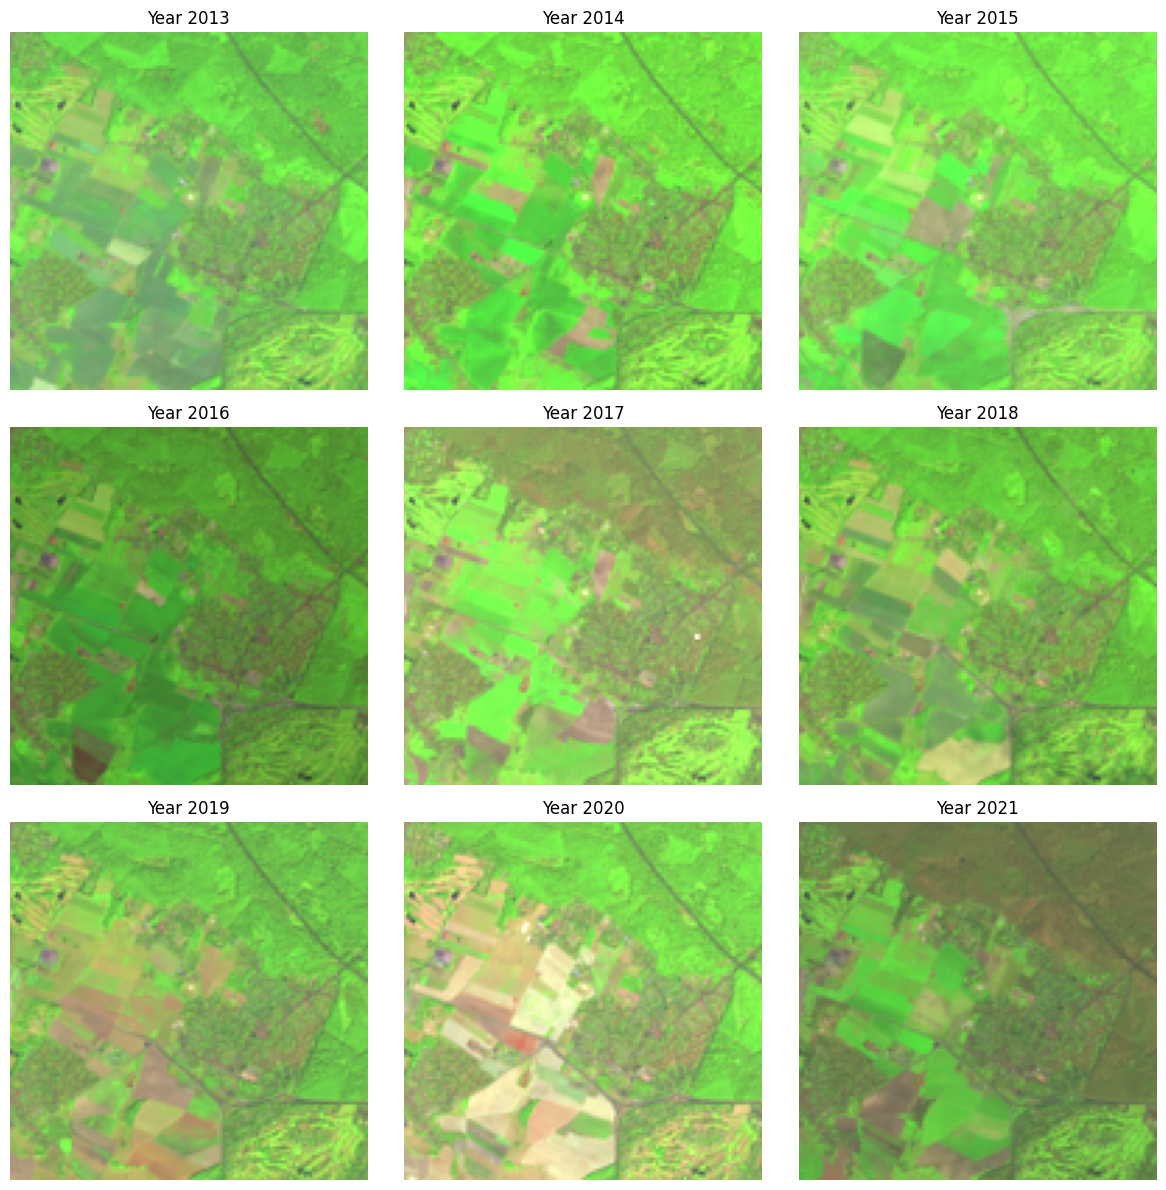

✅ Dataset inspection completed successfully


In [7]:
import pandas as pd

print("\n" + "=" * 80)
print("📦 TEMPORAL PATCH DATASET OVERVIEW")
print("=" * 80)

# ---------------- BASIC INFO ----------------
print(f"Total number of patches : {len(dataset)}")
print(f"Number of cities        : {len(dataset.cities)}")
print(f"Cities                 : {list(dataset.cities.keys())}")
print(f"Socioeco aligned        : {len(dataset.socioeco) == len(dataset.patches)}")

print("\nPatches per city:")
for city, patches in dataset.cities.items():
    print(f"  • {city:<10}: {len(patches)} patches")

print("=" * 80)

# ---------------- SAMPLE TABLE ----------------
print("\n📊 SAMPLE SUMMARY (first 10 patches)\n")

rows = []
for i in range(min(10, len(dataset))):
    patch = dataset[i]                    # TemporalPatch
    imgs, socio = dataset.get_pair(i)     # ML data
    city, _ = dataset.index[i]

    rows.append({
        "global_idx": i,
        "city": city,
        "patch_id": patch.patch_id,
        "n_years": len(patch),
        "years": f"{min(patch.years)}–{max(patch.years)}",
        "imgs_shape": imgs.shape,
        "socioeco_shape": socio.shape,
    })

df = pd.DataFrame(rows)
display(df)

print("=" * 80)

# ---------------- DETAILED SINGLE SAMPLE ----------------
idx = 300
patch = dataset[idx]
imgs, socio = dataset.get_pair(idx)
city, _ = dataset.index[idx]

print("\n🧩 DETAILED SAMPLE INSPECTION")
print("=" * 80)
print(f"Global index   : {idx}")
print(f"City           : {city}")
print(f"Patch ID       : {patch.patch_id}")
print(f"Years          : {patch.years}")
print(f"Number of years: {len(patch)}")

print("\n🖼️ Image data")
print(f"  imgs shape   : {imgs.shape}")
print(f"  imgs dtype   : {imgs.dtype}")

print("\n📊 Socio-economic data")
print(f"  socioeco shape : {socio.shape}")
print(f"  socioeco dtype : {socio.dtype}")

print("\n🗺️ Spatial information")
print(f"  coords shape    : {patch.coords.shape}")
print(f"  iris_index shape: {patch.iris_index.shape}")

print("=" * 80)

# ---------------- VISUAL PROOF ----------------
print("\n🖼️ TEMPORAL VISUALIZATION (one patch across years)")
print("Displaying satellite images across years...\n")

patch.plot_across_years()

print("=" * 80)
print("✅ Dataset inspection completed successfully")
print("=" * 80)


In [37]:
imgs, socioeco_vector = dataset.get_pair(0)
print(imgs.shape)
print(socioeco_vector.shape)

(9, 128, 128, 3)
(9, 96)
